In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.smalldiffusion.diffusion import ScheduleLogLinear, classifier_free_guidance_training_loop, conditioned_samples
from src.smalldiffusion.data import StarDataset
from src.smalldiffusion.model import (
    TimeInputMLPConditional, get_sigma_embeds
)

import torch.distributions as dist
import torch
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


def plot_batch(batch, label=None, marker='.', color=None):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker=marker, label=label, color=color)
    # plt.xlim(-4,4)
    # plt.ylim(-4,4)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w



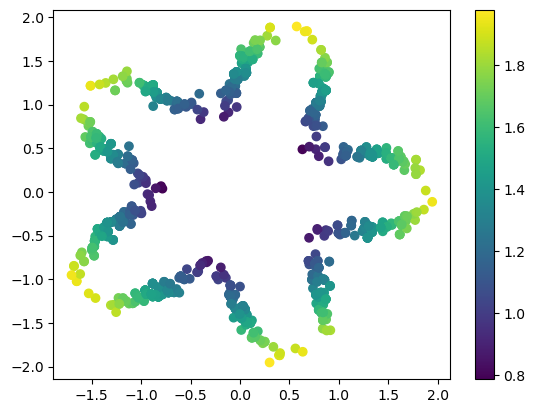

<Axes: ylabel='Count'>

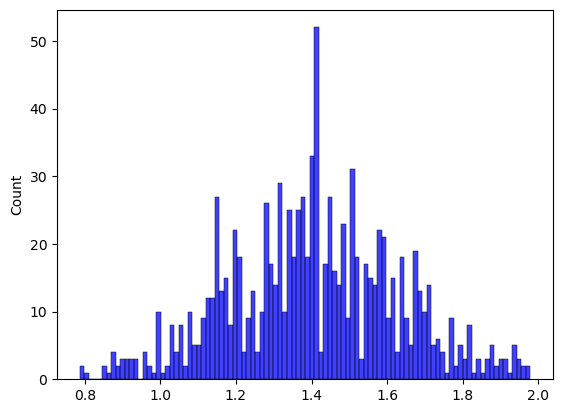

In [4]:

# sample from the dataset given a radius
# Define a desired radius distribution
radius_mean = 1.4
radius_std = 0.2
radius_dist = dist.Normal(radius_mean, radius_std)

dataset = StarDataset(radius=2, n_points=1000, seed=0, sample_dist=radius_dist)
loader = DataLoader(dataset, batch_size=100, shuffle=True)
fig, ax = plt.subplots()
im = ax.scatter(dataset.data[:, 0], dataset.data[:, 1], c=dataset.radii[:, 0])
fig.colorbar(im, ax=ax)
plt.show()

sns.histplot(dataset.radii[:, 0], bins=100, color='blue', label='radius')


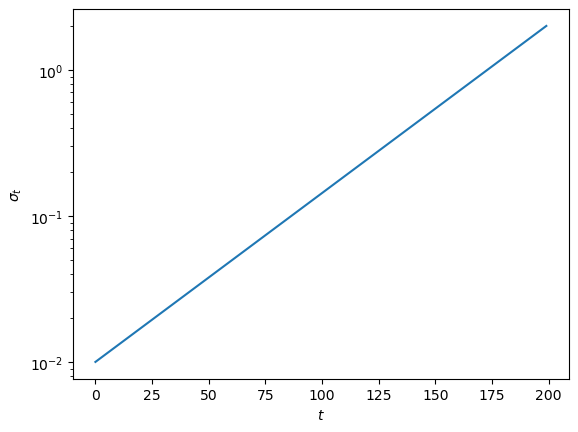

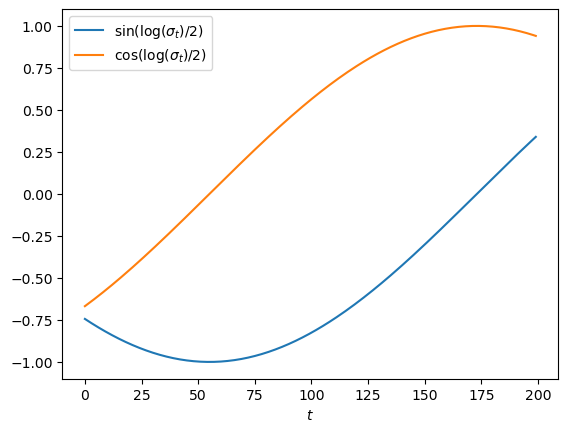

In [5]:
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=2)
plt.plot(schedule.sigmas)
plt.xlabel('$t$')
plt.ylabel('$\sigma_t$')
plt.yscale('log')
plt.show()

sx, sy = get_sigma_embeds(len(schedule), schedule.sigmas).T
plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [6]:
model = TimeInputMLPConditional(dim=2, cond_dim=1, cond_hid_dim=16, hidden_dims=(16,128,256,128,16))
# trainer = classifier_free_guidance_training_loop(loader, model, schedule, epochs=5000, lr=1e-3, drop_prob=0.2)
# losses = [ns.loss.item() for ns in trainer]
# # save model
# torch.save(model.state_dict(), './checkpoints/star_model.pth')

# load model
model.load_state_dict(torch.load('./checkpoints/star_model.pth'))

<All keys matched successfully>

In [7]:
plt.plot(moving_average(losses, 100))
plt.show()

NameError: name 'losses' is not defined

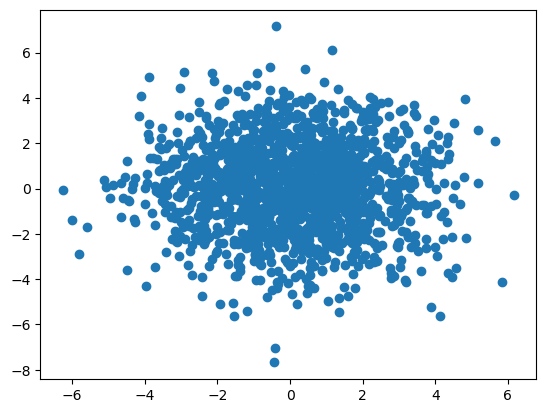

In [8]:
xT = model.rand_input(1500)* schedule.sample_sigmas(50)[0]
plt.scatter(xT[:,0], xT[:,1])

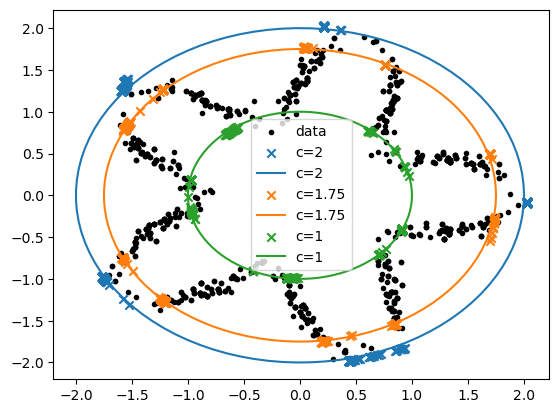

In [9]:
# For DDPM sampling, change to gam=1, mu=0.5
# For DDIM sampling, change to gam=1, mu=0
plot_batch(dataset.data, label='data', marker='.', color='black')
# plt.scatter(dataset.data[:, 0], dataset.data[:, 1], c=dataset.radii[:, 0], label='data')

guide_w = 5
gam=1
mu=0
steps=50
t = np.linspace(0, 2*np.pi, 100)
num_samples = 1500
radii = [2,1.75, 1]

# conditions = None
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=num_samples, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=none', marker='.')

for r in radii:
    conditions = torch.ones(num_samples,1)*r
    *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=num_samples, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
    plot_batch(x0, label=f'c={r}', marker='x')
    plt.plot(r*np.cos(t), r*np.sin(t), label=f'c={r}')

# conditions = torch.ones(num_samples,1)*3
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=num_samples, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=3', marker='x')

# conditions = torch.ones(num_samples,1)*2
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=num_samples, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=2', marker='x')
# # plot a circle of the radius
# plt.plot(2*np.cos(t), 2*np.sin(t), label='c=2')

# conditions = torch.ones(num_samples,1)*1
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=num_samples, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=1', marker='x')
# plt.plot(1*np.cos(t), 1*np.sin(t), label='c=1')

# conditions = torch.ones(num_samples,1)*1.75
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=num_samples, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=1.75', marker='x')

# conditions = torch.ones(num_samples,1)*0.1
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=num_samples, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=0.1', marker='x')

plt.legend()



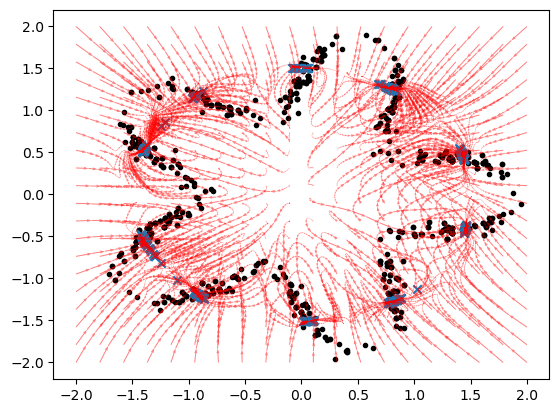

In [53]:
plot_batch(dataset.data, label='data', marker='.', color='black')

# plot xT - denoised(x0) for different levels of noise and x0
# make a grid of xT

num_samples = 400
xTs = torch.linspace(-2, 2, steps=int(np.sqrt(num_samples)))
xTs = torch.stack(torch.meshgrid(xTs, xTs), dim=-1).reshape(-1, 2)

# denoise samples
guide_w = 2.0
gam=1
mu=0.0
steps=50
r = 1.5
conditions = torch.ones(num_samples,1)*r
# conditions = None
*xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), xt=xTs, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
x0 = x0.detach().cpu()
xts = [x.detach().cpu() for x in xts]
# plot_batch(x0, label=f'c={r}', marker='x')
# plt.plot(r*np.cos(t), r*np.sin(t), label=f'c={r}')
plot_batch(x0, label=f'denoised c={r}', marker='x')
# plot_batch(xTs, label='xT', marker='+', color='red')
# plot the denoising path as a vector between them
plt.quiver(xTs[:,0], xTs[:,1], xts[0][:,0]-xTs[:,0], xts[0][:,1]-xTs[:,1], color='red', scale=1, scale_units='xy', angles='xy', width=0.002, alpha=0.5) #, headwidth=2, headlength=2, alpha=0.5, label='difference')
for t in range(1, len(xts)):
    # print(xts[t-1][:,0], xts[t-1][:,1], xts[t][:,0]-xts[t-1][:,0], xts[t][:,1]-xts[t-1][:,1])
    plt.quiver(xts[t-1][:,0], xts[t-1][:,1], xts[t][:,0]-xts[t-1][:,0], xts[t][:,1]-xts[t-1][:,1], color='red', scale=1, scale_units='xy', angles='xy', width=0.002, alpha=0.5)#, headwidth=1, headlength=2, alpha=0.5, label='path')

# plt.quiver(xTs[:,0], xTs[:,1], x0[:,0]-xTs[:,0], x0[:,1]-xTs[:,1], color='red', scale=1, scale_units='xy', angles='xy', width=0.002, headwidth=1, headlength=2, label='difference')
# plt.legend()



Now - consider a noisy reward model - radii not perfect. Also make OOD radii better, currently we can't even tell what the c=5 should be.
- can do this by filtering by radii, or following a distribution of radii.

What is p(x) under the generating model? assuming gaussians, can get something. 

<Axes: ylabel='Count'>

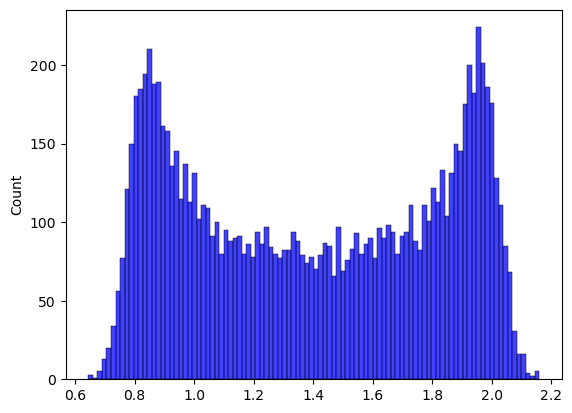

In [19]:
import seaborn as sns

sns.histplot(dataset.radii[:, 0], bins=100, color='blue', label='radius')

# we want the distribution to be normal with mean 1.4 and std 1
# we can do this by filtering radii


If you add noise to the denoising process, do you generate points that are very different? 

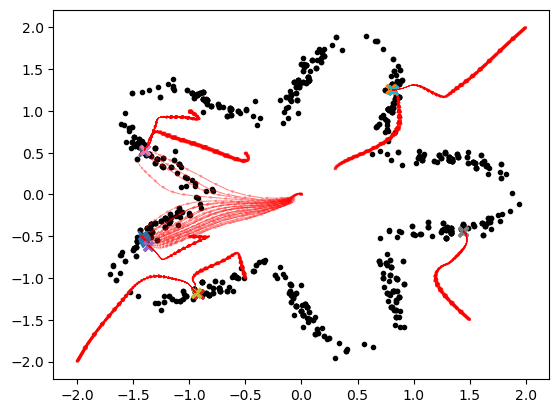

In [52]:
# uncertainty estimation
plot_batch(dataset.data, label='data', marker='.', color='black')
guide_w = 2.0
gam=1
mu=0.0
steps=50
r = 1.5
conditions = torch.ones(num_samples,1)*r
num_samples = 25

starting_points = [[0,0], [0.3, 0.3], [-1,1], [-0.5, -1], [-1, -0.5], [-0.5,0.5], [-1,1], [1.5,-1.5], [-2,-2], [2,2]]
# we can estimate the uncertainty by sampling from the model and then computing the variance of the samples

for starting_point_x, starting_point_y in starting_points:
    xTs_x = torch.linspace(starting_point_x-0.01, starting_point_x+0.01, steps=int(np.sqrt(num_samples)))
    xTs_y = torch.linspace(starting_point_y-0.01, starting_point_y+0.01, steps=int(np.sqrt(num_samples)))
    xTs = torch.stack(torch.meshgrid(xTs_x, xTs_y), dim=-1).reshape(-1, 2)
    # denoise samples

    # conditions = None
    *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), xt=xTs, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
    x0 = x0.detach().cpu()
    xts = [x.detach().cpu() for x in xts]
    # plot_batch(x0, label=f'c={r}', marker='x')
    # plt.plot(r*np.cos(t), r*np.sin(t), label=f'c={r}')
    plot_batch(x0, label=f'denoised c={r}', marker='x')
    # plot_batch(xTs, label='xT', marker='+', color='red')
    # plot the denoising path as a vector between them
    plt.quiver(xTs[:,0], xTs[:,1], xts[0][:,0]-xTs[:,0], xts[0][:,1]-xTs[:,1], color='red', scale=1, scale_units='xy', angles='xy', width=0.002, alpha=0.5) #, headwidth=2, headlength=2, alpha=0.5, label='difference')
    for t in range(1, len(xts)):
        # print(xts[t-1][:,0], xts[t-1][:,1], xts[t][:,0]-xts[t-1][:,0], xts[t][:,1]-xts[t-1][:,1])
        plt.quiver(xts[t-1][:,0], xts[t-1][:,1], xts[t][:,0]-xts[t-1][:,0], xts[t][:,1]-xts[t-1][:,1], color='red', scale=1, scale_units='xy', angles='xy', width=0.002, alpha=0.5)#, headwidth=1, headlength=2, alpha=0.5, label='path')
